<a href="https://colab.research.google.com/github/BarathSrinivasan2002/Deep_Learning_Face_mask_detection/blob/main/SOA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/BarathSrinivasan2002/Deep_Learning_Face_mask_detection.git

Cloning into 'Deep_Learning_Face_mask_detection'...
remote: Enumerating objects: 1779, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 1779 (delta 30), reused 33 (delta 12), pack-reused 1715 (from 2)
Receiving objects: 100% (1779/1779), 400.03 MiB | 60.78 MiB/s, done.
Resolving deltas: 100% (865/865), done.


In [2]:
%cd Deep_Learning_Face_mask_detection

/content/Deep_Learning_Face_mask_detection


In [3]:
!ls

 face-mask-detection	       'Supervised_Learning copy.ipynb'
 labels.csv		        Supervised_Learning_Facemask_Detection_CNN.ipynb
 Preprocessing_Pipeline.ipynb   Supervised_Learning.ipynb
 README.md		        Unsupervised_learning_autoencoders.ipynb
 requirements.txt	        Unsupervised_learning_autoencoders.py


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [5]:
# Function to parse XML annotations
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []

    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})

    return annotations

In [6]:
# Paths to dataset
ANNOTATION_PATH = '/content/Deep_Learning_Face_mask_detection/face-mask-detection/versions/1/annotations'
IMAGE_PATH = '/content/Deep_Learning_Face_mask_detection/face-mask-detection/versions/1/images'

# Load XML files
xml_files = [os.path.join(ANNOTATION_PATH, f) for f in os.listdir(ANNOTATION_PATH) if f.endswith('.xml')]
data = []

In [7]:
# Extract annotations
for xml_file in xml_files:
    annotations = parse_xml(xml_file)
    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

# Create DataFrame
df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
print(df['label'].value_counts())

label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64


In [8]:
# Label mapping
label_map = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}

In [9]:
# Image processing
face_images = []
face_labels = []

for _, row in df.iterrows():
    bbox = row['bbox']
    image = cv2.imread(os.path.join(IMAGE_PATH, row['filename']))
    image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)  # Normalize using MobileNetV2 preprocessing

    face_images.append(image)
    face_labels.append(label_map[row['label']])

face_images = np.array(face_images, dtype='float32')
face_labels = to_categorical(np.array(face_labels))  # Convert labels to categorical format


In [10]:
# Data Augmentation
augmentation = ImageDataGenerator(
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=25,
    fill_mode='nearest'
)

# Splitting Data
train_x, test_val_x, train_y, test_val_y = train_test_split(face_images, face_labels, test_size=0.3, stratify=face_labels)
test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, test_size=0.5, stratify=test_val_y)


In [ ]:
print(f"Train: {train_x.shape}, Validation: {val_x.shape}, Test: {test_x.shape}")

Train: (2850, 224, 224, 3), Validation: (611, 224, 224, 3), Test: (611, 224, 224, 3)


In [11]:
### Model 1: MobileNetV2
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet.trainable = False  # Freeze base model

model_mobilenet = Sequential([
    mobilenet,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_mobilenet.summary())

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,286,659 (39.24 MB)

 Trainable params: 8,028,675 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [12]:
# Training MobileNet
history_mobilenet = model_mobilenet.fit(
    augmentation.flow(train_x, train_y, batch_size=32),
    validation_data=(val_x, val_y),
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 409ms/step - accuracy: 0.7432 - loss: 5.6194 - val_accuracy: 0.8903 - val_loss: 0.3275
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.8281 - loss: 0.4505 - val_accuracy: 0.9116 - val_loss: 0.3420
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 309ms/step - accuracy: 0.8685 - loss: 0.3989 - val_accuracy: 0.8871 - val_loss: 0.3024
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 309ms/step - accuracy: 0.8661 - loss: 0.3839 - val_accuracy: 0.9100 - val_loss: 0.2904
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.8674 - loss: 0.3827 - val_accuracy: 0.9067 - val_loss: 0.3419
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 305ms/step - accuracy: 0.8801 - loss: 0.3355 - val_accuracy: 0.9231 - val_loss: 0.2635
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.8867 - loss: 0.2856 - val_accuracy: 0.9264 - val_loss: 0.2334
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.8739 - loss: 0.3338 - val_accu

In [13]:
### Model 2: MobileNetV2 Trained from Scratch (No Pretrained Weights)
mobilenet_scratch = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
mobilenet_scratch.trainable = True  # All layers trainable

model_mobilenet_scratch = Sequential([
    mobilenet_scratch,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_mobilenet_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_mobilenet_scratch.summary())

# Train from Scratch
history_mobilenet_scratch = model_mobilenet_scratch.fit(
    augmentation.flow(train_x, train_y, batch_size=32),
    validation_data=(val_x, val_y),
    epochs=10
)

# Evaluate
scratch_eval = model_mobilenet_scratch.evaluate(test_x, test_y)
print(f"MobileNetV2 (Scratch) Test Accuracy: {scratch_eval[1]:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,286,659 (39.24 MB)

 Trainable params: 10,252,547 (39.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

None
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 99s 572ms/step - accuracy: 0.7436 - loss: 3.4876 - val_accuracy: 0.7938 - val_loss: 0.9474
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 311ms/step - accuracy: 0.8097 - loss: 0.6990 - val_accuracy: 0.7938 - val_loss: 0.9336
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 312ms/step - accuracy: 0.8540 - loss: 0.4833 - val_accuracy: 0.7938 - val_loss: 0.7412
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.8709 - loss: 0.5412 - val_accuracy: 0.7938 - val_loss: 0.9483
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 314ms/step - accuracy: 0.8236 - loss: 0.4128 - val_accuracy: 0.7938 - val_loss: 0.8018
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 313ms/step - accuracy: 0.8643 - loss: 0.3661 - val_accuracy: 0.7938 - val_loss: 0.7856
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 313ms/step - accuracy: 0.8654 - loss: 0.3151 - val_accuracy: 0.7938 - val_loss: 0.8570
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 311ms/step - accuracy: 0.8514 - loss: 0.3194 - val

In [14]:
### Model 3: Fine-Tune MobileNetV2 (Unfreeze Some Layers)
# Reload MobileNetV2 with pretrained weights
mobilenet_finetune = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 20 layers for fine-tuning
mobilenet_finetune.trainable = True
for layer in mobilenet_finetune.layers[:-20]:
    layer.trainable = False  # Freeze all except last 20 layers

model_mobilenet_finetune = Sequential([
    mobilenet_finetune,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_mobilenet_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
print(model_mobilenet_finetune.summary())

# Train with Fine-Tuning
history_mobilenet_finetune = model_mobilenet_finetune.fit(
    augmentation.flow(train_x, train_y, batch_size=32),
    validation_data=(val_x, val_y),
    epochs=10
)

# Evaluate
finetune_eval = model_mobilenet_finetune.evaluate(test_x, test_y)
print(f"MobileNetV2 (Fine-Tuned) Test Accuracy: {finetune_eval[1]:.4f}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,286,659 (39.24 MB)

 Trainable params: 9,234,755 (35.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

None
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 414ms/step - accuracy: 0.7890 - loss: 0.9436 - val_accuracy: 0.8740 - val_loss: 0.4557
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.8920 - loss: 0.2880 - val_accuracy: 0.8691 - val_loss: 0.5191
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 302ms/step - accuracy: 0.9169 - loss: 0.2305 - val_accuracy: 0.8723 - val_loss: 0.7742
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 305ms/step - accuracy: 0.9345 - loss: 0.2018 - val_accuracy: 0.8445 - val_loss: 0.9250
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 305ms/step - accuracy: 0.9425 - loss: 0.1632 - val_accuracy: 0.8822 - val_loss: 0.5350
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 305ms/step - accuracy: 0.9463 - loss: 0.1485 - val_accuracy: 0.8871 - val_loss: 0.6777
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 306ms/step - accuracy: 0.9521 - loss: 0.1362 - val_accuracy: 0.9247 - val_loss: 0.4030
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.9481 - loss: 0.1401 - val

In [ ]:
### Model 2: Basic CNN
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_cnn.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Training Basic CNN
history_cnn = model_cnn.fit(
    augmentation.flow(train_x, train_y, batch_size=32),
    validation_data=(val_x, val_y),
    epochs=10
)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 381ms/step - accuracy: 0.8037 - loss: 1.4834 - val_accuracy: 0.9116 - val_loss: 0.2958
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step - accuracy: 0.8999 - loss: 0.3311 - val_accuracy: 0.9182 - val_loss: 0.2541
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 353ms/step - accuracy: 0.9208 - loss: 0.2679 - val_accuracy: 0.9345 - val_loss: 0.2187
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 336ms/step - accuracy: 0.9163 - loss: 0.2724 - val_accuracy: 0.9411 - val_loss: 0.2147
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.9266 - loss: 0.2627 - val_accuracy: 0.9394 - val_loss: 0.2148
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 338ms/step - accuracy: 0.9214 - loss: 0.2700 - val_accuracy: 0.9427 - val_loss: 0.1945
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 341ms/step - accuracy: 0.9314 - loss: 0.2322 - val_accuracy: 0.9296 - val_loss: 0.2570
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 336ms/step - accuracy: 0.9246 - loss: 0.2387 - val_accu

In [ ]:
# Evaluating Models
mobilenet_eval = model_mobilenet.evaluate(test_x, test_y)
cnn_eval = model_cnn.evaluate(test_x, test_y)

print(f"MobileNetV2 Test Accuracy: {mobilenet_eval[1]:.4f}")
print(f"Basic CNN Test Accuracy: {cnn_eval[1]:.4f}")

NameError: name 'model_mobilenet' is not defined

In [15]:
### Optimized AutoML Hyperparameter Tuning with Keras Tuner
!pip install keras-tuner -q
from kerastuner import RandomSearch
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf

def build_model(hp):
    # Define tunable hyperparameters with reduced search space
    model = Sequential([
        MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
        GlobalAveragePooling2D(),  # More efficient than Flatten()
        Dense(units=hp.Int('dense_units', 64, 128, step=64), activation='relu'),
        Dropout(rate=hp.Float('dropout_rate', 0.2, 0.4, step=0.1)),  # Narrower range
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-3, 1e-4])  # Fewer choices
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Reduced from 5
    executions_per_trial=1,  # No redundant runs
    directory='tuner_results',
    project_name='face_mask_detection_optimized'
)

# Run the search with early stopping
tuner.search(
    train_x, train_y,  # Using raw data (no augmentation during search)
    batch_size=32,
    validation_data=(val_x, val_y),
    epochs=5,  # Reduced from 10
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_accuracy')
    ]
)

# Get and evaluate best model
best_model = tuner.get_best_models(num_models=1)[0]
print("\nEvaluating Best Model on Test Set:")
test_loss, test_acc = best_model.evaluate(test_x, test_y)
print(f"\nBest Model Test Accuracy: {test_acc:.4f}")

# Display best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print("\nBest Hyperparameters:")
print(f"- Dense Units: {best_hps.get('dense_units')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

Trial 3 Complete [00h 02m 04s]
val_accuracy: 0.9067103266716003

Best val_accuracy So Far: 0.9067103266716003
Total elapsed time: 00h 06m 14s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluating Best Model on Test Set:
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9087 - loss: 0.5509

Best Model Test Accuracy: 0.9067

Best Hyperparameters:
- Dense Units: 64
- Dropout Rate: 0.2
- Learning Rate: 0.001


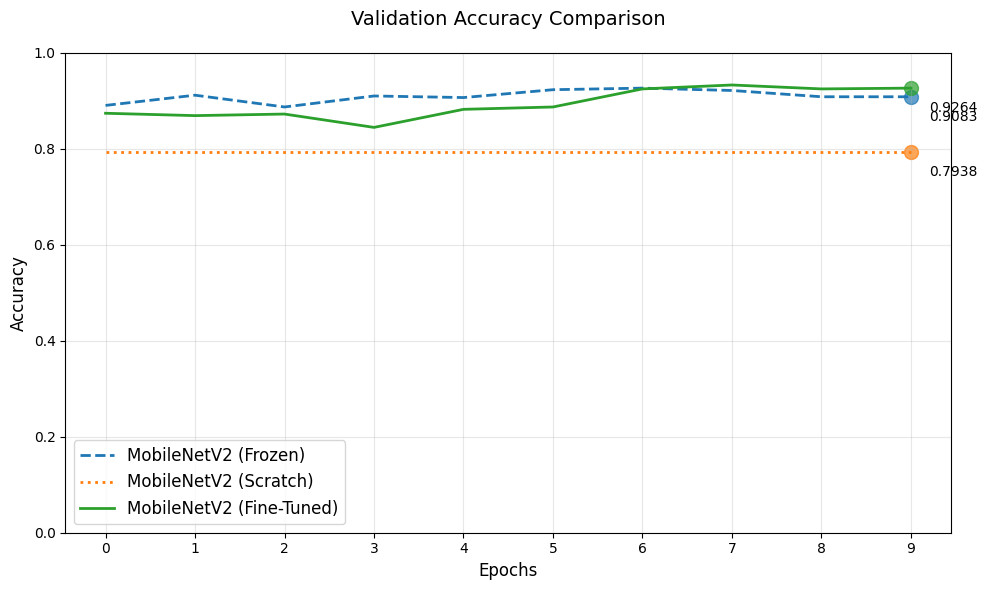

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot validation accuracies
plt.plot(history_mobilenet.history['val_accuracy'],
         label='MobileNetV2 (Frozen)', linestyle='--', linewidth=2)
plt.plot(history_mobilenet_scratch.history['val_accuracy'],
         label='MobileNetV2 (Scratch)', linestyle=':', linewidth=2)
plt.plot(history_mobilenet_finetune.history['val_accuracy'],
         label='MobileNetV2 (Fine-Tuned)', linewidth=2)

# Customize plot
plt.title('Validation Accuracy Comparison', fontsize=14, pad=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(range(0, 10))  # Assuming 10 epochs
plt.ylim(0, 1.0)  # Full accuracy range
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Annotate final accuracy values
for history, label in zip([history_mobilenet, history_mobilenet_scratch, history_mobilenet_finetune],
                         ['Frozen', 'Scratch', 'Fine-Tuned']):
    final_acc = history.history['val_accuracy'][-1]
    plt.scatter(9, final_acc, s=100, alpha=0.7)
    plt.text(9.2, final_acc-0.05, f'{final_acc:.4f}', fontsize=10)

plt.tight_layout()
plt.show()